In [1]:
import numpy as np 
import matplotlib as mpl
%matplotlib widget
import matplotlib.pyplot as plt

import gorgon

# Define

## Import data

In [42]:
def import_stuff( filepath: str ):
    B = gorgon.import_from_bin(f"{filepath}/B_processed_real.bin")

    with open(f"{filepath}/params_cpp.csv", "r") as f:
        params = np.array( f.readline().split(","), dtype=np.float32 )
        
    interest_points_theta = []
    interest_points_phi = []
    interest_points_r = []
    interest_points_w = []
        
    with open(f"{filepath}/interest_points_cpp.csv", "r") as f:
        lines = f.readlines()

        for line in lines:
            point = np.array( line.split(","), dtype=np.float32 )
            interest_points_theta.append( point[0] )
            interest_points_phi.append( point[1] )
            interest_points_r.append( point[2] )
            interest_points_w.append( (1-point[3], point[3], point[3]) )

        interest_points_theta = np.array(interest_points_theta)
        interest_points_phi = np.array(interest_points_phi)
        interest_points_r = np.array(interest_points_r)
        interest_points_w = np.array(interest_points_w)

    return B, params, interest_points_theta, interest_points_phi, interest_points_r, interest_points_w

## Plot surface

In [49]:
def plot_surface( filename: str ):
    B, params, _, _, _, _ = import_stuff( filename )

    theta, phi = np.meshgrid( np.linspace( 0, np.pi*0.9, 40 ), np.linspace( -np.pi, np.pi, 80 ), indexing='ij' )
    R = gorgon.Me25_poly( params, theta, phi )

    earth_pos = [29.75, 58, 58]

    X,Y,Z = gorgon.spherical_to_cartesian( R, theta, phi, earth_pos )

    B_thing = B[np.array(X, dtype=np.int16), np.array(Y, dtype=np.int16), np.array(Z, dtype=np.int16)]

    B_thing_norm = np.linalg.norm( B_thing, axis=2 )

    saturation = 0.8

    B_thing_norm = B_thing_norm * (B_thing_norm < np.max(B_thing_norm)*saturation) + np.max(B_thing_norm)*saturation * (B_thing_norm >= np.max(B_thing_norm)*saturation)

    color = (B_thing_norm - np.min(B_thing_norm)) / (np.max(B_thing_norm) - np.min(B_thing_norm))
    cmap = plt.get_cmap("inferno")
    color = cmap( color )
    
    fig = plt.figure()
    fig.set_figwidth(8)
    fig.set_figheight(8)
    ax = fig.add_subplot(projection='3d')
    # ax.set(xlabel=r"$x \in [-30; 128] R_E$", ylabel=r"$y \in [-58; 58] R_E$", zlabel=r"$z \in [-58; 58] R_E$")
    # plt.suptitle("Surface of the magnetopause drawn from the fitted function.")
    # plt.title("Colours represent the norm of the magnetic field.")

    ax.set_xlim(0, B.shape[0])
    ax.set_ylim(0, B.shape[1])
    ax.set_zlim(0, B.shape[2])
    
    ax.patch.set_facecolor('black')
    ax.set_axis_off()

    ax.figure.subplots_adjust(0, 0, 1, 1)

    ax.plot_surface(X, Y, Z, facecolors=color, shade=False)

    norm = mpl.colors.Normalize(vmin=np.min(B_thing_norm), vmax=np.max(B_thing_norm))
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                    ax = ax, label=r"$||\mathbf{B}||$ [$T$]", shrink=0.5)

## Plot scatter

In [48]:
def plot_scatter( filename: str ):
    B, params, ip_theta, ip_phi, ip_r, ip_w = import_stuff( filename )

    earth_pos = [29.75, 58, 58]

    X,Y,Z = gorgon.spherical_to_cartesian( ip_r, ip_theta, ip_phi, earth_pos )
    
    fig = plt.figure()
    fig.set_figwidth(8)
    fig.set_figheight(8)
    ax = fig.add_subplot(projection='3d')
    # ax.set(xlabel=r"$x \in [-30; 128] R_E$", ylabel=r"$y \in [-58; 58] R_E$", zlabel=r"$z \in [-58; 58] R_E$")
    # plt.suptitle("Surface of the magnetopause drawn from the fitted function.")
    # plt.title("Colours represent the norm of the magnetic field.")

    ax.set_xlim(0, B.shape[0])
    ax.set_ylim(0, B.shape[1])
    ax.set_zlim(0, B.shape[2])
    
    ax.patch.set_facecolor('black')
    ax.set_axis_off()

    ax.figure.subplots_adjust(0, 0, 1, 1)

    ax.scatter(X, Y, Z, c=ip_w)

# Main

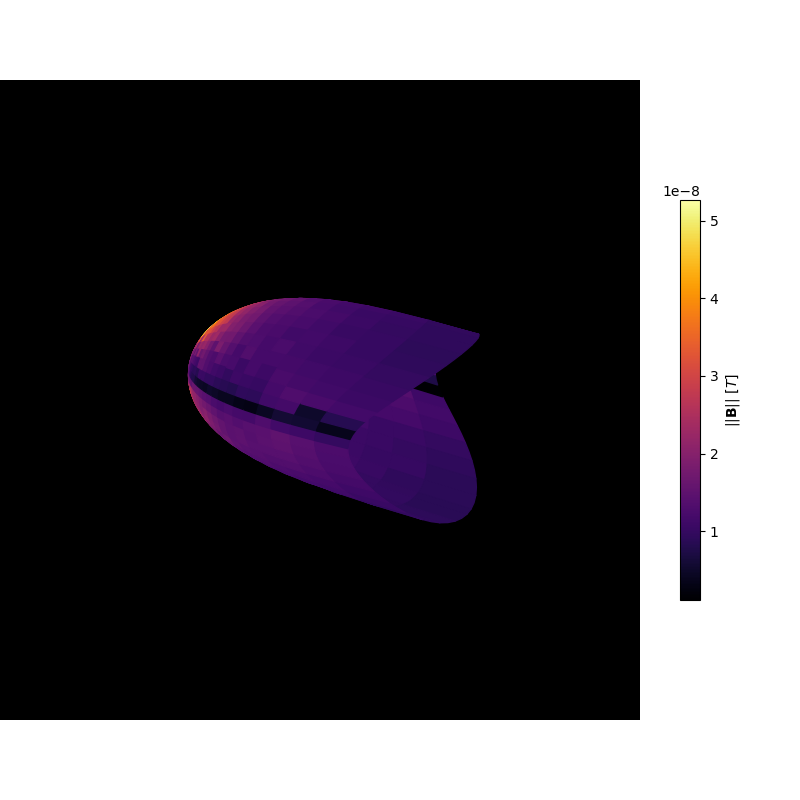

In [54]:
plot_surface( "../data/Run1_28800" )

In [52]:
plt.close()